# Allegro/BERT model training

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
TRAINING_DIR='/content/drive/MyDrive/AGH/2/Advanced Data Mining/project/training'
LOGS_DIR='/content/drive/MyDrive/AGH/2/Advanced Data Mining/project/logs'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/AGH/2/Advanced Data Mining/project/cleaned_data.csv', sep=';')

## Pre-processing

In [5]:
def plot_hist(df, bins: np.ndarray, title: str, xlabel: str, ylabel: str):

    prices = df["price_pln"].values

    ranges = pd.cut(prices, bins=bins)
    counts = ranges.value_counts().sort_index()

    print("Min number of samples in bin: ", counts.min())
    print("Max number of samples in bin: ", counts.max())

    plt.figure(figsize=(14, 6))
    counts.plot(kind="bar")

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of cars")
    plt.xlabel("Price bracket")
    plt.title("Logarithmic Bins – Distribution of Car Prices")
    plt.tight_layout()

    plt.show()

In [6]:
def generate_cm(y_test,y_pred):
    """
    Function to generate confusion matrix
    :param y_test:
    :param y_pred:
    :return: cm, cm_normalized
    """
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    return cm, cm_normalized

In [7]:
def plot_cm(cm, title: str = "Confusion Matrix", xlabel: str = "Predicted Label", ylabel: str = "True Label"):

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.xticks(np.arange(cm.shape[1]))
    plt.yticks(np.arange(cm.shape[0]))

    plt.tight_layout()

    plt.show()

In [15]:
def custom_train_test_split(df, bins: np.ndarray, test_size: float = 0.2, random_state: int = 42):
    """
    Function to get train and test data
    :param random_state:
    :param test_size:
    :param df: Dataframe
    :param bins
    :return: X_train, X_test, y_train, y_test
    """
    df['price_bin'] = pd.cut(df['price_pln'], bins=bins, right=False, labels=False)

    print("Number of classes:", df['price_bin'].nunique())

    df.dropna(subset=['price_bin'], inplace=True)

    X = df['description'].values
    y = df['price_bin'].values
    return train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

In [9]:
def preprocessing(df, step: int = 20_000, min_price: int = 20_000, max_price: int = 300_000):
    """
    Function to preprocess the data
    :param df: Dataframe
    :param step: Step size for bins
    :param min_price: Minimum price for bins
    :param max_price: Maximum price for bins
    :return: df, bins
    """
    clean_df = df

    df = clean_df.drop(
        [
            "url",
            "color",
            "posted_date",
            "price_net_info",
            "location",
            "price",
            "country_of_origin",
        ],
        axis=1,
        errors="ignore",
    )

    df["capacity"] = (
        df["capacity"]
        .str.replace(" cm3", "", regex=False)
        .str.replace(" ", "")
        .astype(float)
    )

    df["power"] = (
        df["power"].str.replace(" ", "").str.replace("KM", "", regex=False).astype(float)
    )

    df["mileage"] = (
        df["mileage"].str.replace(" km", "", regex=False).str.replace(" ", "").astype(float)
    )

    df["price_pln"] = (
        df["price_pln"].str.replace(" ", "").str.replace(",", ".").astype(float)
    )

    df = df.dropna(
        subset=[
            "model",
            "condition",
            "fuel",
            "brand",
            "body_type",
            "accident_free",
            "year",
            "capacity",
            "power",
            "mileage",
            "seats",
            "description",
        ]
    )
    lin_bins = np.arange(min_price, max_price + step, step)  # edges: [min, min+step, ..., max]
    log_bins = np.logspace(
        np.log10(min_price),
        np.log10(max_price),
        num=len(lin_bins),
        dtype=float
    )
    log_bins = log_bins.astype(int)
    return df, lin_bins, log_bins

## Data exploration

In [10]:
df, lin_bins, log_bins = preprocessing(data, step = 20_000, min_price = 20_000, max_price = 300_000)
prices = df["price_pln"].values

Min number of samples in bin:  138
Max number of samples in bin:  2878


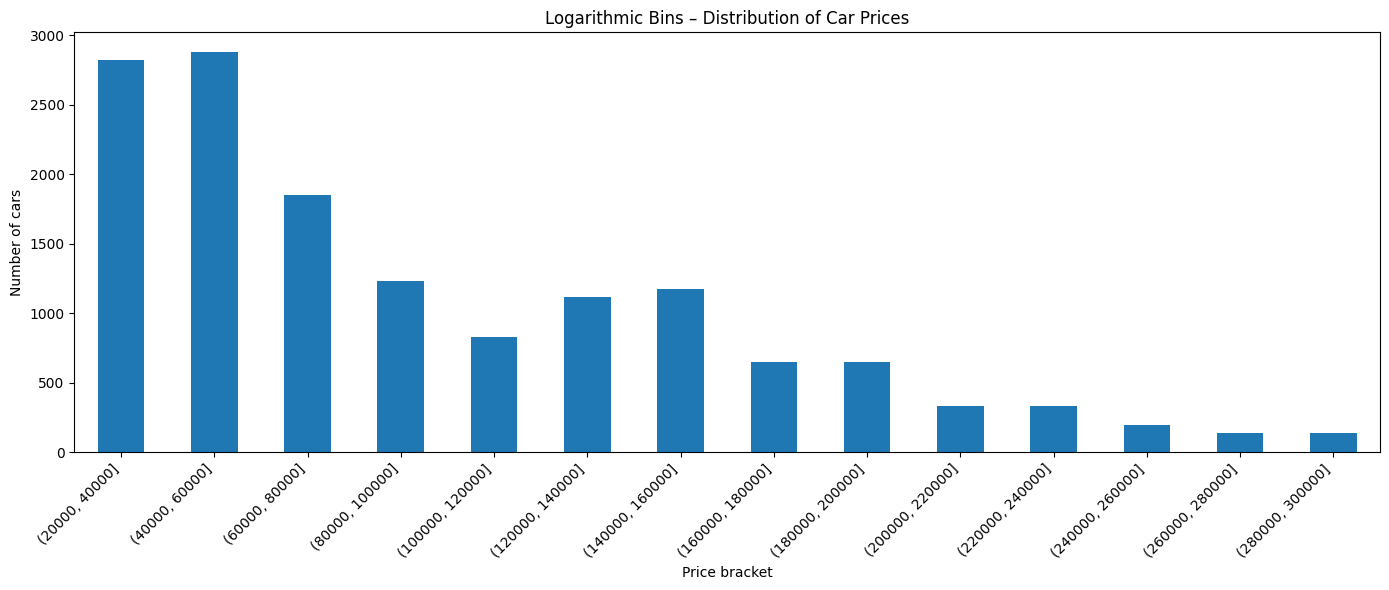

In [11]:
# --- linear bins ---
plot_hist(df, bins=lin_bins, title="Linear Bins – Distribution of Car Prices",
          xlabel="Number of cars", ylabel="Linear Bins")

Min number of samples in bin:  376
Max number of samples in bin:  1539


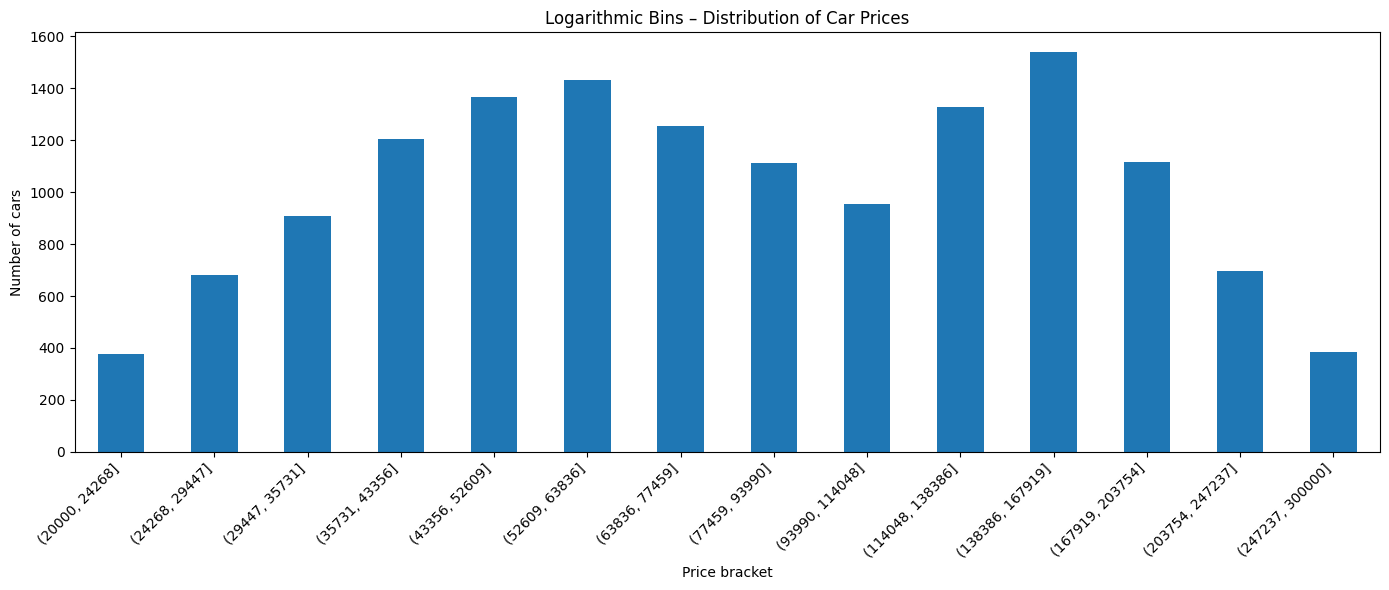

In [12]:
# --- logarithmic bins ---
plot_hist(df, bins=log_bins, title="Logarithmic Bins – Distribution of Car Prices",
          xlabel="Number of cars", ylabel="Logarithmic Bins")

In [16]:
X_train, X_test, y_train, y_test = custom_train_test_split(df, log_bins, test_size=0.2, random_state=42)

print(df.describe().apply(lambda s: s.apply('{0:.5f}'.format)))
print(df.head())
print(y_test)

Number of classes: 14
             seats         year     capacity        power        mileage  \
count  14367.00000  14367.00000  14367.00000  14367.00000    14367.00000   
mean       3.47609   2019.64620   2108.65295    141.79349   133768.04455   
std        1.45170      5.26188    545.65208     43.03065   132486.19534   
min        1.00000   1955.00000      1.00000     15.00000        1.00000   
25%        3.00000   2017.00000   1968.00000    125.00000       10.00000   
50%        3.00000   2020.00000   2000.00000    140.00000   125000.00000   
75%        3.00000   2025.00000   2287.00000    163.00000   216000.00000   
max        9.00000   2026.00000  21433.00000   2299.00000  2060400.00000   

          price_pln    price_bin  
count   14367.00000  14367.00000  
mean    97605.03530      6.58982  
std     63710.85910      3.45420  
min     20000.00000      0.00000  
25%     45900.00000      4.00000  
50%     76400.00000      6.00000  
75%    140833.77000     10.00000  
max    299999

## Initial model

This is the base model:

**allegro/herbert-base-cased**

We will try to predict 14 price classes.

In [33]:
!pip install sacremoses --quiet

In [19]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score


MODEL_NAME = "allegro/herbert-base-cased"
NUM_LABELS = 14
MAX_LENGTH = 512
BATCH_SIZE = 16
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## DATA LOADER
class CarDescriptionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = CarDescriptionDataset(
    texts=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)

test_dataset = CarDescriptionDataset(
    texts=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    nm_acc_1 = compute_near_miss_accuracy(labels, preds, tolerance=1)

    return {
        'accuracy': acc,
        'f1': f1,
        'near_miss_acc_1': nm_acc_1
    }

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/marcin_ai/training',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/marcin_ai/logs/',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()

print("Evaluating on test set...")
results = trainer.evaluate()

print(results)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Starting training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.950000,1.892666,0.260612,0.224986
2,1.705800,1.802644,0.276618,0.257313
3,1.584300,1.602607,0.364997,0.360140
4,1.355600,1.585046,0.393528,0.383302
5,1.173500,1.633790,0.414405,0.416114
6,1.064900,1.564999,0.468685,0.465960
7,0.856400,1.597857,0.504175,0.503680
8,0.703700,1.683378,0.510786,0.510994
9,0.538800,1.717385,0.530271,0.529872
10,0.479300,1.753268,0.537578,0.537472


Evaluating on test set...


{'eval_loss': 1.5649993419647217, 'eval_accuracy': 0.46868475991649267, 'eval_f1': 0.4659602179493653, 'eval_runtime': 13.5403, 'eval_samples_per_second': 212.256, 'eval_steps_per_second': 13.294, 'epoch': 10.0}


### Another iteration of allegro/herbert

Since the accuracy improved a lot in later iterations, let's give the model another 10 epochs to train.

In [21]:

MODEL_NAME = "allegro/herbert-base-cased"
NUM_LABELS = 14
MAX_LENGTH = 512
BATCH_SIZE = 16
EPOCHS = 20

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/marcin_ai/training',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/marcin_ai/logs/',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("Resuming training for an additional 10 epochs (Total 20)...")

checkpoint_path = '/content/drive/MyDrive/marcin_ai/training/checkpoint-7190'

trainer.train(resume_from_checkpoint=checkpoint_path)


print("Evaluating on test set...")
results = trainer.evaluate()

print(results)

Resuming training for an additional 10 epochs (Total 20)...


Epoch,Training Loss,Validation Loss,Accuracy,F1
11,0.684900,1.866291,0.508699,0.507405
12,0.575400,1.884094,0.522269,0.521060
13,0.537700,1.952592,0.532359,0.531845
14,0.387400,2.042537,0.537578,0.537190
15,0.341900,2.137341,0.535143,0.534219
16,0.287700,2.233628,0.544885,0.545431
17,0.208200,2.360701,0.544885,0.545040
18,0.157600,2.390862,0.545581,0.545735
19,0.113400,2.476049,0.553236,0.552926
20,0.092000,2.488742,0.556715,0.556640


Evaluating on test set...


{'eval_loss': 1.5649993419647217, 'eval_accuracy': 0.46868475991649267, 'eval_f1': 0.4659602179493653, 'eval_runtime': 13.6305, 'eval_samples_per_second': 210.851, 'eval_steps_per_second': 13.206, 'epoch': 20.0}


In [24]:
save_path = "/content/drive/MyDrive/marcin_ai/final_herbert_model"
trainer.model.save_pretrained(save_path)

print(f"Model and Tokenizer saved to: {save_path}")

Model and Tokenizer saved to: /content/drive/MyDrive/marcin_ai/final_herbert_model


### Metrics

Let's see some metrics to decide where to go from here.

Generating predictions on the test set...


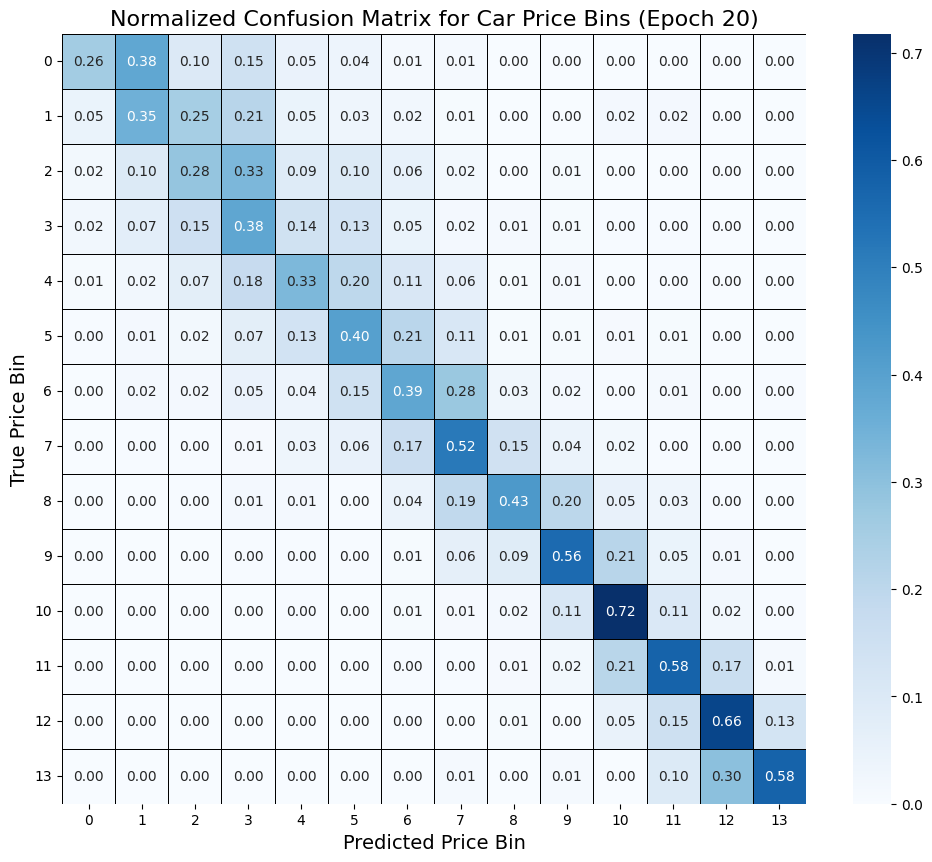

In [27]:
print("Generating predictions on the test set...")
predictions = trainer.predict(test_dataset)

y_true = predictions.label_ids

# Argmax(-1) takes the class with the highest probability from the logits
y_pred = predictions.predictions.argmax(-1)


def plot_confusion_matrix(y_true, y_pred, class_labels, title='Confusion Matrix'):

    ## CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)

    # This shows what percentage of true label 'i was predicted as label j
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))

    ax = sns.heatmap(
        cm_percent,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
        linewidths=.5,
        linecolor='black',
        cbar=True
    )


    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted Price Bin', fontsize=14)
    ax.set_ylabel('True Price Bin', fontsize=14)
    plt.yticks(rotation=0)

    plt.show()


CLASS_LABELS = [str(i) for i in range(NUM_LABELS)]

plot_confusion_matrix(
    y_true,
    y_pred,
    class_labels=CLASS_LABELS,
    title='Normalized Confusion Matrix for Car Price Bins (Epoch 20)'
)

### Near-Miss accuracy

Since the model is not performing that well, let's see if the near-miss metric would tell us something.

Since there are 14 classes (that is quite a lot), mabye the model is at least in the bull-park and misses by a hair.

In [36]:
import numpy as np
from transformers import EvalPrediction

def compute_near_miss_accuracy(y_true, y_pred, tolerance=1):
    """
    Calculates the Near-Miss Accuracy, where a prediction is correct
    if it is within the tolerance (inclusive) of the true label.

    Args:
        y_true (np.ndarray): The array of true labels.
        y_pred (np.ndarray): The array of predicted labels.
        tolerance (int): The maximum allowed difference between prediction and true label.
                         A tolerance of 1 means |y_pred - y_true| <= 1.

    Returns:
        float: The calculated Near-Miss Accuracy.
    """

    absolute_difference = np.abs(y_pred - y_true)

    is_correct = absolute_difference <= tolerance

    near_miss_accuracy = np.mean(is_correct)

    return near_miss_accuracy


print("Generating predictions on the test set...")
predictions = trainer.predict(test_dataset)

y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)


## (Tolerance = 1)
near_miss_acc_1 = compute_near_miss_accuracy(y_true, y_pred, tolerance=1)

print("-" * 50)
print(f"Standard Accuracy (Tolerance 0): {np.mean(y_true == y_pred):.4f}")
print(f"Near-Miss Accuracy (Tolerance 1): {near_miss_acc_1:.4f}")
print("-" * 50)


## Tolerance = 2
near_miss_acc_2 = compute_near_miss_accuracy(y_true, y_pred, tolerance=2)
print(f"Near-Miss Accuracy (Tolerance 2): {near_miss_acc_2:.4f}")

Generating predictions on the test set...


--------------------------------------------------
Standard Accuracy (Tolerance 0): 0.4687
Near-Miss Accuracy (Tolerance 1): 0.8031
--------------------------------------------------
Near-Miss Accuracy (Tolerance 2): 0.9189


### Fine tuning

Since the Near-Miss accuracy is way better, let's try to fine tune the model some more.

We will slow down the learning rate by a lot, and try to run it for 3 more epochs.

In [29]:
NEW_TOTAL_EPOCHS = 23
FT_BATCH_SIZE = 16
FT_LEARNING_RATE = 5e-6 ## 5e-5 -> 5e-6
OUTPUT_DIR = '/content/drive/MyDrive/marcin_ai/training'

latest_checkpoint_path = get_last_checkpoint(OUTPUT_DIR)

if latest_checkpoint_path is None:
    print("WARNING: Could not find a specific checkpoint path. Using the current 'model' object.")
    resume_from_path = OUTPUT_DIR
else:
    print(f"Loading best weights from checkpoint: {latest_checkpoint_path}")
    model = model.from_pretrained(
        latest_checkpoint_path,
        num_labels=NUM_LABELS
    ).to(device)
    resume_from_path = latest_checkpoint_path


training_args_ft = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NEW_TOTAL_EPOCHS,
    learning_rate=FT_LEARNING_RATE,
    per_device_train_batch_size=FT_BATCH_SIZE,
    per_device_eval_batch_size=FT_BATCH_SIZE,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/marcin_ai/logs/',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
)

trainer_ft = Trainer(
    model=model,
    args=training_args_ft,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print(f"Starting fine-tuning for 3 additional epochs (Total {NEW_TOTAL_EPOCHS}) with LR={FT_LEARNING_RATE}...")
trainer_ft.train(resume_from_checkpoint=resume_from_path)

print("Evaluating on test set after fine-tuning...")
results_ft = trainer_ft.evaluate()

print(results_ft)

Loading best weights from checkpoint: /content/drive/MyDrive/marcin_ai/training/checkpoint-14380
Starting fine-tuning for 3 additional epochs (Total 23) with LR=5e-06...


	logging_steps: 10 (from args) != 50 (from trainer_state.json)


Epoch,Training Loss,Validation Loss,Accuracy,F1
21,0.126300,2.564930,0.556715,0.557425
22,0.089400,2.615804,0.557759,0.557702
23,0.089200,2.648992,0.558455,0.558498


Evaluating on test set after fine-tuning...


{'eval_loss': 1.5649993419647217, 'eval_accuracy': 0.46868475991649267, 'eval_f1': 0.4659602179493653, 'eval_runtime': 13.6587, 'eval_samples_per_second': 210.416, 'eval_steps_per_second': 13.178, 'epoch': 23.0}


### Fine tuned model performance

Let's see the confusion matrix for the fine-tuned model

Loading best fine-tuned model from: /content/drive/MyDrive/marcin_ai/training/checkpoint-16537
Generating predictions on the test set from the fine-tuned model...


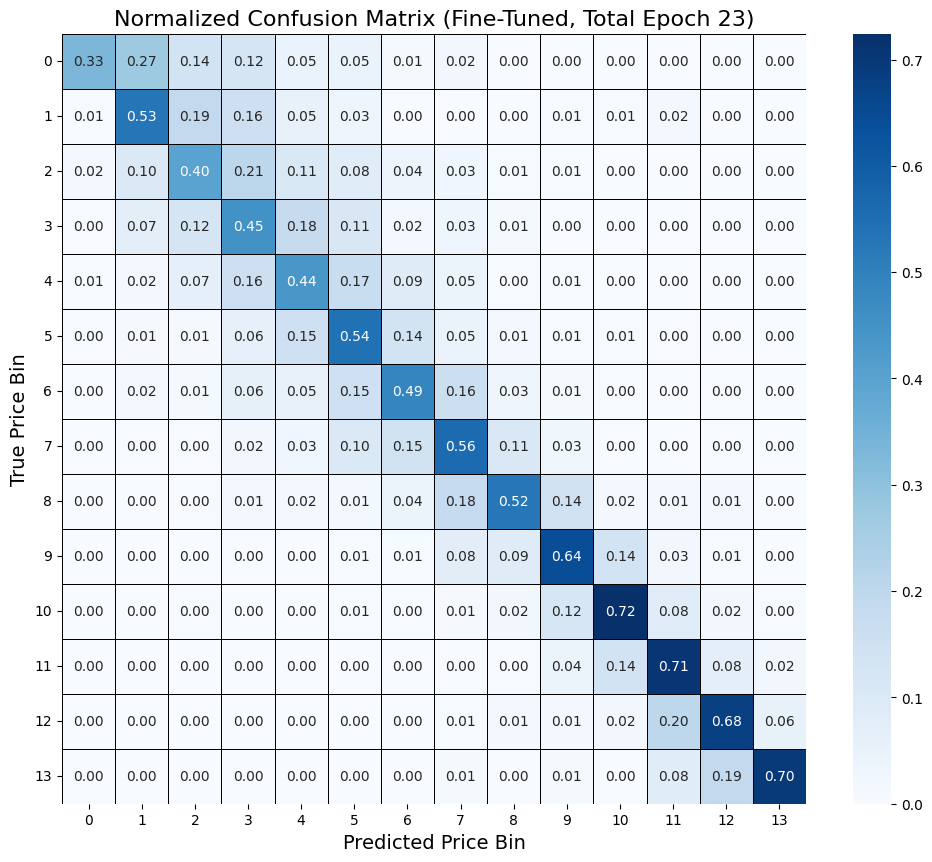


--- Plotting Complete ---
The final confusion matrix has been generated.


In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers.trainer_utils import get_last_checkpoint

MODEL_NAME = "allegro/herbert-base-cased"
NUM_LABELS = 14
MAX_LENGTH = 512
OUTPUT_DIR = '/content/drive/MyDrive/marcin_ai/training'

class CarDescriptionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
test_dataset = CarDescriptionDataset(
    texts=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)

best_model_path = get_last_checkpoint(OUTPUT_DIR) or OUTPUT_DIR
print(f"Loading best fine-tuned model from: {best_model_path}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = AutoModelForSequenceClassification.from_pretrained(
    best_model_path,
    num_labels=NUM_LABELS
).to(device)

trainer_eval = Trainer(model=model_ft, args=TrainingArguments(output_dir="./temp_eval"))

print("Generating predictions on the test set from the fine-tuned model...")
predictions_ft = trainer_eval.predict(test_dataset)

y_true_ft = predictions_ft.label_ids
y_pred_ft = predictions_ft.predictions.argmax(-1)


def plot_confusion_matrix(y_true, y_pred, class_labels, title, filename):
    """Calculates and plots the normalized confusion matrix."""

    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))

    ax = sns.heatmap(
        cm_percent,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
        linewidths=.5,
        linecolor='black',
        cbar=True
    )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted Price Bin', fontsize=14)
    ax.set_ylabel('True Price Bin', fontsize=14)
    plt.yticks(rotation=0)

    plt.show()

CLASS_LABELS = [str(i) for i in range(NUM_LABELS)]

plot_confusion_matrix(
    y_true_ft,
    y_pred_ft,
    class_labels=CLASS_LABELS,
    title='Normalized Confusion Matrix (Fine-Tuned, Total Epoch 23)',
    filename='confusion_matrix_ft_final.png'
)

print("\n--- Plotting Complete ---")
print("The final confusion matrix has been generated.")

In [43]:
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers.trainer_utils import get_last_checkpoint
from sklearn.metrics import accuracy_score

# --- 1. Define the Near-Miss Metric Function ---

def compute_near_miss_accuracy(y_true, y_pred, tolerance=1):
    """
    Calculates the Near-Miss Accuracy, where a prediction is correct
    if it is within the tolerance (inclusive) of the true label (± tolerance).
    """
    absolute_difference = np.abs(y_pred - y_true)
    is_correct = absolute_difference <= tolerance
    near_miss_accuracy = np.mean(is_correct)
    return near_miss_accuracy

# --- 2. Configuration and Setup (Ensure X_test, y_test are available) ---
MODEL_NAME = "allegro/herbert-base-cased"
NUM_LABELS = 14
MAX_LENGTH = 512
OUTPUT_DIR = '/content/drive/MyDrive/marcin_ai/training' # Your checkpoint path

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
test_dataset = CarDescriptionDataset(
    texts=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)


best_model_path = get_last_checkpoint(OUTPUT_DIR) or OUTPUT_DIR
model_ft = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=NUM_LABELS).to(device)

trainer_eval = Trainer(model=model_ft, args=TrainingArguments(output_dir="./temp_eval"))
predictions_ft = trainer_eval.predict(test_dataset)

y_true_ft = predictions_ft.label_ids
y_pred_ft = predictions_ft.predictions.argmax(-1)

test_dataset = CarDescriptionDataset(
    texts=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)

best_model_path = get_last_checkpoint(OUTPUT_DIR) or OUTPUT_DIR
print(f"Loading best fine-tuned model from: {best_model_path}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = AutoModelForSequenceClassification.from_pretrained(
    best_model_path,
    num_labels=NUM_LABELS
).to(device)

trainer_eval = Trainer(model=model_ft, args=TrainingArguments(output_dir="./temp_eval"))

print("Generating predictions on the test set from the fine-tuned model...")
predictions_ft = trainer_eval.predict(test_dataset)

y_true_ft = predictions_ft.label_ids
y_pred_ft = predictions_ft.predictions.argmax(-1)

standard_acc = accuracy_score(y_true_ft, y_pred_ft)

near_miss_acc_1 = compute_near_miss_accuracy(y_true_ft, y_pred_ft, tolerance=1)

near_miss_acc_2 = compute_near_miss_accuracy(y_true_ft, y_pred_ft, tolerance=2)

print("\n--- Model Accuracy Metrics (Total Epoch 23) ---")
print(f"Standard Accuracy (Tolerance 0): {standard_acc:.4f} ({standard_acc * 100:.2f}%)")
print(f"Near-Miss Accuracy (Tolerance 1): {near_miss_acc_1:.4f} ({near_miss_acc_1 * 100:.2f}%)")
print(f"Near-Miss Accuracy (Tolerance 2): {near_miss_acc_2:.4f} ({near_miss_acc_2 * 100:.2f}%)")

Loading best fine-tuned model from: /content/drive/MyDrive/marcin_ai/training/checkpoint-16537
Generating predictions on the test set from the fine-tuned model...



--- Model Accuracy Metrics (Total Epoch 23) ---
Standard Accuracy (Tolerance 0): 0.5581 (55.81%)
Near-Miss Accuracy (Tolerance 1): 0.8253 (82.53%)
Near-Miss Accuracy (Tolerance 2): 0.9311 (93.11%)
